# Downloading CMIP6 Experiment Data

### NOTE: Not used in final pipeline

This notebook steps through how to query and download the CMIP6 historic and projection datasets used later to build our ensemble projections. 

For a great rundown of what is going on in this notebook that I found *after* working on it, check this jupyter book out: [Earth and Environmental Data Science](https://earth-env-data-science.github.io/lectures/models/cmip.html)

This is an alteration of `CMIPfromMD.ipynb` incorporating some lessons learned while debugging, aimed at minimizing the one-off code for catching stragglers by leaning into the `xmip` preprocessing steps.

This new process should not require any changes within code chunks **except** for setting the querying information and which variables to download.

In [18]:
from matplotlib import pyplot as plt # Plotting
import numpy as np                   
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from dask.diagnostics import ProgressBar
from numpy import unique
import cf_xarray
import operator
import os
import sys
sys.path.append('Code/')
import fcts
import glob
import xesmf as xe
import dask
import xmip 

# XMIP preprocessing
from xmip.preprocessing import combined_preprocessing

# Function to help handle irregular grids
from xmip.preprocessing import replace_x_y_nominal_lat_lon

# Set Model Info/Criteria for Dataset Query

This section sets up the configuration options including:
 * Model sources
 * Variable(s) of interest
 * Frequency of measurements
 * output path for saving subset data from CMIP6 models

These settings are used to query a catalog of available models and experiments. This is where we are selective on what models we include in the ensemble.

In [19]:
# Output path - Where we want to save things
# Make sure we match the folder to the right scenario or if its historical
path = "/Users/adamkemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6/SSP5_85/"

# Set the tableid (tells us temporal resolution)
# (based on the frequency of measurements)
table_id = 'Omon'

# Enter the experiments of interest {'historical', 'ssp585', 'ssp126'}
filter_list    = ['ssp585']  # Can take multiple for querying
experiment_run = 'ssp585'    # Just a string for string matching since we're typically doing 1 at a time
grp1           = 'source_id' # used for grouping normally don't need to change
grp2           = 'member_id' # used for grouping normally don't need to change

# Model Source IDs we care about
# # Ones with a hash on the right weren't working for Andrew, lets try again
source_list = [
    #'IPSL-CM6A-LR', #
    'CMCC-CM2-SR5',
    #'MIROC6', #
    'CanESM5',
    'MRI-ESM2-0',
    #'HadGEM3-GC31-LL', # 
    'GFDL-CM4',
    'CESM2',
    'CESM2-WACCM',
    #'CIESM', #
    #'CNRM-CM6-1', #
    #'CNRM-ESM2-1', #
    'CanESM5-CanOE',
    'EC-Earth3',
    #'EC-Earth3-Veg', #
    #'EC-Earth3-Veg-LR', #
    'FGOALS-g3',
    'FGOALS-f3-L',
    'FIO-ESM-2-0',
    #'GISS-E2-1-G', #
    'INM-CM4-8',
    'INM-CM5-0'
    #'MIROC-ES2L', #
    #'NESM3', #
    #'NorESM2-LM', #
    #'NorESM2-MM', #
    #'UKESM1-0-LL' #
]

## Variable Settings

The code below is set up to pull a single variable from the models above for surface and bottom layers (done separately) up to a maximum depth. It is written to be run once for each scenario, variable, and depth layer.

For a full list of variable options [check here](https://docs.google.com/spreadsheets/u/1/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271)


We can also adjust the lat/lon scope in the following code.

In [22]:
# Enter the var of interest {so, thetao, tos}
variable_id = 'so' 

# Key:
# thetao = sea water potential temperature deg c
# so     = sea water salinity
# tos    = sea surface temperature deg C

# True/False for Top or Bottom Layer
TOP = False

# Set some filtering options for x,y,z extents
# These are the limits GLORYs was downloaded for crossboundary
mod_lims = {
    "xmin" : -100,
    "xmax" : -40,
    "ymin" : 20,
    "ymax" : 70,
    "max_z" : 400
}

# Query Model Catalog for Suitable Runs

Using those config options we can query the cmip6 consolidated stores catalog for the suite of models that fit the criteria we need. 

This catalog contains information on which institution ran the model, which scenario it used, and other information about the model. But most importantly, it provides a `ztore` field which has information on where to access the data.

Another avenue for accessing this caatalog is [intake-esm](https://intake-esm.readthedocs.io/en/stable/index.html) to load a collection of zarr stores on Google Cloud Storage. There are [other options](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html) to access the data too, but these are the ones I've seen so far.

In [23]:
# Data catalog is stored as a 30MB CSV file
# the columns correspond to the CMIP6 controlled vocab
AllModels = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

# Filter down from all models using the config options in the above chunk(s)
df_var = AllModels.query(f"variable_id == '{variable_id}' & table_id == '{table_id}' & experiment_id == @filter_list")
filteredModels = fcts.ExperimentFilter(df_var, grp1, grp2)

# Isolate the source list explicitly
filteredModels_grid = filteredModels.query(f"source_id == @source_list").reset_index(drop=True)

# look at it's structure
print(filteredModels_grid[0:3])

      source_id  member_id  Number_of_exp  activity_id institution_id  \
0         CESM2  r10i1p1f1              1  ScenarioMIP           NCAR   
1   CESM2-WACCM   r1i1p1f1              1  ScenarioMIP           NCAR   
2  CMCC-CM2-SR5   r1i1p1f1              1  ScenarioMIP           CMCC   

  experiment_id table_id variable_id grid_label  \
0        ssp585     Omon          so         gn   
1        ssp585     Omon          so         gr   
2        ssp585     Omon          so         gn   

                                              zstore  dcpp_init_year   version  
0  gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585...             NaN  20200528  
1  gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/...             NaN  20190815  
2  gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-CM2-SR5...             NaN  20200622  


# Iterate Over Model List and Extract + Save Data

From that list of suitable candidate models, we can open slice out the variable(s) we need for the xyz limits we're using. 

This chunk of code saves files in the location set by the `path` object stored earlier under the `RawTmpFiles_24/` subfolder.

Bottom layer datasets are renamed for identification later. 



In [15]:
# Only has to be defined once
gcs = gcsfs.GCSFileSystem(token = 'anon')

# Loop over each row in the query results
for i in range(len(filteredModels_grid)):

    # Record information on the source, member, experiment, and variable
    source_id     = filteredModels_grid.source_id[i]
    member_id     = filteredModels_grid.member_id[i]
    experiment_id = filteredModels_grid.experiment_id[i]
    variable_id   = filteredModels_grid.variable_id[i]
    
    # Set up the export path(s)

    # Toggle for surface/bottom - sets filename convention for saving
    if TOP == True:
        savePath = f'{path}RawTmpFiles_24/Surface_{variable_id}_{source_id}_{member_id}_{experiment_id}.nc'
        
    else:
        savePath = f'{path}RawTmpFiles_24/Bottom_{variable_id}_{source_id}_{member_id}_{experiment_id}.nc'
    
    # Skip these steps if the downloads exist already
    fileExists = os.path.exists(savePath)
    if fileExists:
        print(f"Skipping {savePath} as it already exists.")
        continue
    

    # Proceed to download if a copy not found
    if fileExists == False :

        # Get the path to a specific zarr store 0 index is first on list
        zstore = filteredModels_grid.zstore.values[i]

        # Create a mutable-mapping-styly interface to the store (lazy-load it)
        mapper = gcs.get_mapper(zstore)

        # open it using xarray and zarr
        ds = xr.open_zarr(mapper, consolidated=True, decode_times=False)

        # Perform xmip preprocessing
        # standardizes lat/lon/depth conventions
        ds = combined_preprocessing(ds)
        # Replace and x and y with lat/lon coords so we can use ds.sel to crop quickly
        ds = replace_x_y_nominal_lat_lon(ds)

        # Adjust xlim for standard 0-360 limits used by xmip.combined_preprocessing
        xmin = mod_lims["xmin"] + 360
        xmax = mod_lims["xmax"] + 360
        ymin = mod_lims["ymin"]
        ymax = mod_lims["ymax"]
        maxDepth = mod_lims["max_z"]

        # Get subset logic for slicing coordinates + Depths
        x_coord = "x"
        y_coord = "y"
        depth_coord = "lev"
        kwlon = {x_coord: slice(xmin, xmax)}
        kwlat = {y_coord: slice(ymin, ymax)}  

        # Subset lat/lon dimensions
        atlantic = ds.sel(**kwlon, **kwlat)

        # Filter Dates for Historical Period and limit scenarios to 2100
        if experiment_id == 'historical':
            atlantic = atlantic.sel(time=slice("1950-01-01", None))

        # End at 2100
        # Need to update this experiment ID for each run
        elif experiment_id == experiment_run:  
            atlantic = atlantic.sel(time = slice(None, '2100-12-30'))

        # If neither ask to specify
        else:
            print("Need to enter date range")


        # Subset top layer if pulling surface
        if TOP == True:
            kwargs = {depth_coord: 0}
            atlantic = atlantic.isel(**kwargs)
            # Rename or just drop?
            #atlantic = atlantic.rename({variable_id : f"surface_{variable_id}", depth_coord: 'surface_lev'})
            atlantic = atlantic.rename({variable_id : f"surface_{variable_id}"})
            


        # Pull up to max depth for bottom
        else:
            # Slice up to the max depth
            kwargs = {depth_coord: slice(0, maxDepth)}
            false_bottom = atlantic.sel(**kwargs)
            temp_array = false_bottom[variable_id]

            # # Step 1: Find the indices of the deepest non-NA value along the "z" dimension
            # Get the bottom z index in space
            depth_indices = fcts.find_deepest_depth_indices_CMIP6(
                ds    = false_bottom, 
                dims0 = y_coord, 
                dims1 = x_coord, 
                variable_id = variable_id, 
                y_coord = y_coord, 
                x_coord = x_coord)
            
            # Create an array for indexing, make the subset/indexing argument
            ind = xr.DataArray(depth_indices, dims = [y_coord, x_coord])
            kwdepth = {depth_coord: ind}

            # Subset and reshape
            dsSel = temp_array.isel(**kwdepth)
            atlantic = dsSel.to_dataset().rename({variable_id : f"bottom_{variable_id}", depth_coord : 'bottom_lev'})


        # Prepare to save
        delayed_obj = atlantic.to_netcdf(savePath, compute=False)

        # Use compute to bring everything over locally
        with ProgressBar():
            results = delayed_obj.compute()


        print(f'Finished {variable_id}_{source_id}_{member_id}_{experiment_id}.nc')

[########################################] | 100% Completed | 105.29 s
Finished so_CESM2_r10i1p1f1_ssp585.nc
[########################################] | 100% Completed | 10.32 ss
Finished so_CESM2-WACCM_r1i1p1f1_ssp585.nc
[########################################] | 100% Completed | 26.11 ss
Finished so_CMCC-CM2-SR5_r1i1p1f1_ssp585.nc
[########################################] | 100% Completed | 21.63 ss
Finished so_CanESM5_r10i1p1f1_ssp585.nc
[########################################] | 100% Completed | 22.67 ss
Finished so_CanESM5-CanOE_r1i1p2f1_ssp585.nc
[########################################] | 100% Completed | 38.04 s
Finished so_EC-Earth3_r101i1p1f1_ssp585.nc
[                                        ] | 0% Completed | 143.00 us

/Users/adamkemberling/Documents/Repositories/lobSDM/.pixi/envs/default/lib/python3.10/site-packages/xmip/preprocessing.py:287: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")


[########################################] | 100% Completed | 37.96 s
Finished so_FGOALS-f3-L_r1i1p1f1_ssp585.nc
[########################################] | 100% Completed | 37.56 s
Finished so_FGOALS-g3_r1i1p1f1_ssp585.nc
[########################################] | 100% Completed | 63.84 s
Finished so_FIO-ESM-2-0_r1i1p1f1_ssp585.nc
[########################################] | 100% Completed | 186.78 s
Finished so_GFDL-CM4_r1i1p1f1_ssp585.nc
[########################################] | 100% Completed | 11.46 ss
Finished so_INM-CM4-8_r1i1p1f1_ssp585.nc
[########################################] | 100% Completed | 11.88 ss
Finished so_INM-CM5-0_r1i1p1f1_ssp585.nc
[########################################] | 100% Completed | 190.05 s
Finished so_MRI-ESM2-0_r1i1p1f1_ssp585.nc


---
# Debugging the bottom layer problems

Need the depth subsetting to not break on irregular grids or if there isn't a z dimensions...

In [33]:
def extract_bottom_layer(ds, variable = "so", z_dim = "lev"):
    """
    Extracts the deepest non-NA value and its corresponding depth from a dataset.

    Parameters:
    - ds (xarray.Dataset): The dataset to process.
    - variable (str): The variable of interest.
    - z_dim (str): The name of the vertical dimension.

    Returns:
    - xarray.Dataset: A 2D dataset with the deepest value and corresponding depth.
    """
    # Identify the non-z dimensions related to the variable
    dims = [dim for dim in ds[variable].dims if dim != z_dim]

    # Ensure the variable exists
    if variable not in ds:
        raise ValueError(f"Variable '{variable}' not found in the dataset.")

    # Step 1: Find the index of the deepest non-NA value along the "z" dimension
    deepest_index = ds[variable].notnull().cumsum(z_dim).argmax(z_dim)

    # Mask indices where all values along "z" are NaN
    valid_mask = ds[variable].notnull().any(z_dim)
    
    # Replace invalid indices with NaN
    deepest_index = xr.where(valid_mask, deepest_index, np.nan)  
    
    # Convert to NumPy array after masking invalid indices
    deepest_index = deepest_index.compute()

    # Step 2: Extract the deepest non-NA value
    bottom_layer = ds[variable].isel({z_dim: deepest_index}).where(valid_mask)

    # Step 3: Extract the corresponding depth values
    bottom_depth = ds[z_dim].isel({z_dim: deepest_index})

    # Step 4: Drop the z dimension and create a new dataset
    bottom_layer = bottom_layer.drop_vars(z_dim, errors="ignore")
    bottom_layer = bottom_layer.assign_coords(bottom_depth=bottom_depth)

    # Step 5: Create a new dataset with the bottom values and depths
    return xr.Dataset({f"{variable}_bottom": bottom_layer, "depth": bottom_depth})

In [34]:
# Get the path to a specific zarr store 0 index is first on list
zstore = filteredModels_grid.zstore.values[2]

# Create a mutable-mapping-styly interface to the store (lazy-load it)
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True, decode_times=False)

# Perform xmip preprocessing
# standardizes lat/lon/depth conventions
ds = combined_preprocessing(ds)
# Replace and x and y with lat/lon coords so we can use ds.sel to crop quickly
ds = replace_x_y_nominal_lat_lon(ds)

# Adjust xlim for standard 0-360 limits used by xmip.combined_preprocessing
xmin = mod_lims["xmin"] + 360
xmax = mod_lims["xmax"] + 360
ymin = mod_lims["ymin"]
ymax = mod_lims["ymax"]
maxDepth = mod_lims["max_z"]

# Get subset logic for slicing coordinates + Depths
x_coord = "x"
y_coord = "y"
depth_coord = "lev"
kwlon = {x_coord: slice(xmin, xmax)}
kwlat = {y_coord: slice(ymin, ymax)}  

# Subset lat/lon dimensions
atlantic = ds.sel(**kwlon, **kwlat)

if TOP == False:
    bottom_ds = extract_bottom_layer(ds = atlantic,  variable = variable_id, z_dim = "lev")

bottom_ds

TypeError: invalid indexer array, does not have integer dtype: array([], shape=(1032, 0, 266), dtype=float64)

<xarray.Dataset> Size: 28kB
Dimensions:        (time: 1032, lev: 50, x: 0, y: 266, vertex: 4, bnds: 2)
Coordinates:
    lat            (x, y) float64 0B dask.array<chunksize=(0, 266), meta=np.ndarray>
  * lev            (lev) float64 400B 0.5126 1.621 2.858 ... 5.498e+03 5.904e+03
    lon            (x, y) float64 0B dask.array<chunksize=(0, 266), meta=np.ndarray>
  * time           (time) int64 8kB 0 708 1416 2148 ... 751152 751884 752616
    lat_verticies  (x, y, vertex) float64 0B dask.array<chunksize=(0, 266, 4), meta=np.ndarray>
    lon_verticies  (x, y, vertex) float64 0B dask.array<chunksize=(0, 266, 4), meta=np.ndarray>
    lev_bounds     (lev, bnds) float64 800B dask.array<chunksize=(50, 2), meta=np.ndarray>
    time_bounds    (time, bnds) float64 17kB dask.array<chunksize=(1032, 2), meta=np.ndarray>
    lon_bounds     (bnds, x, y) float64 0B dask.array<chunksize=(1, 0, 266), meta=np.ndarray>
    lat_bounds     (bnds, x, y) float64 0B dask.array<chunksize=(1, 0, 266), meta=np.ndarray>
  * x              (x) float64 0B 
  * y              (y) float64 2kB 50.01 50.12 50.23 50.51 ... 69.64 69.93 70.0
Dimensions without coordinates: vertex, bnds
Data variables:
    so             (time, lev, x, y) float32 0B dask.array<chunksize=(8, 50, 0, 266), meta=np.ndarray>
Attributes: (12/51)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    cmor_version:           3.5.0
    ...                     ...
    title:                  CMCC-CM2-SR5 output prepared for CMIP6
    tracking_id:            hdl:21.14100/442a20a3-f35d-4083-9e89-3aa49d758d6c...
    variable_id:            so
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/442a20a3-f35d-4083-9e89-3aa49d758d6c...
    version_id:             v20200622

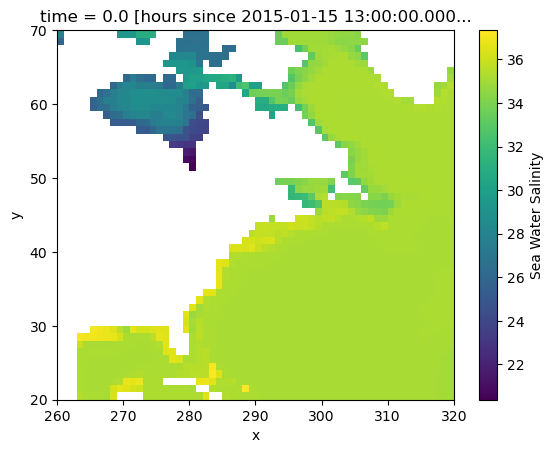

In [ ]:
bottom_ds.isel(time = 0).so_bottom.plot()

---

## Making sure we can regrid later

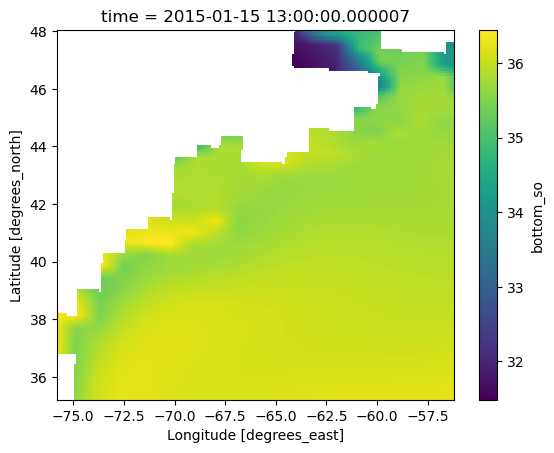

In [ ]:
# Can this guy be regrid, or did we completely break that?
dataset = atlantic # Change this to a file we just saved
UsrName = "adamkemberling"

# Load the reference grid we want to regrid to
glorys_path    = f"/Users/{UsrName}/Library/CloudStorage/Box-Box/RES_Data/GLORYs/NW_Atl_MonthlyTemps/"
glorys_grid = f"{glorys_path}Climatology1993to2023.nc"
glorys_clim = xr.open_dataset(glorys_grid)

# Make the regridder
regridder = xe.Regridder(
    dataset, 
    glorys_clim, 
    'bilinear', 
    periodic = False) #Since this is not global we don't need to pass periodic

# Put it into the dict
#regrid_ds[id] =  
regridder(dataset).isel(time = 0).bottom_so.plot()

---

# Debugging failed downloads:

Due to inconsistencies between the models, the code above will fail on occassion. These can be due to a number of problems including: trying to load too much data at a time with compute(), variable/index name differences, and multiIndex usage.

The three primary reasons the original code was failing was:
 - too much data (ds.compute()) to load without first subsetting
 - incorrect x,y dimension names for subsetting dimensions
 - multiIndex structure used for unstructured grids that used vertices (j,i) as coordinates


#### Presently, These are the model runs that are failing and their causes:

 * thetao_GFDL-CM4_r1i1p1f1_ssp585.nc <- Problem was loading with compute() at beginning

 * thetao_EC-CESM2_r1i1p1f1_ssp585.nc <- x is not a valid dimension

 * thetao_EC-Earth3-Veg_r1i1p1f1_ssp585.nc <- x is not a valid dimension

 * thetao_EC-Earth3-Veg-LR_r1i1p1f1_ssp585.nc <- x is not a valid dimension

 * thetao_HadGEM3-GC31-LL_r1i1p1f3_ssp585.nc <- x is not a valid dimension

 * thetao_MIROC6_r10i1p1f1_ssp585.nc <- No depth units

 * thetao_NESM3_r1i1p1f1_ssp585.nc <- 'x' is not a valid dimension

 * thetao_NorESM2-LM_r1i1p1f1_ssp585.nc <- if len(ds[variable_id][x_coord].dims) == 2: list index out of range

 * thetao_NorESM2-MM_r1i1p1f1_ssp585.nc <- 'x' is not a valid dimension

 * thetao_CMCC-CM2-SR5_r1i1p1f1_ssp585.nc <- operands could not be broadcast together with shapes (292, 362) (292, 362, 4) ()

They can be opened for inspection this way:


In [7]:
# Get the row/index of a single model:

# thetao_CESM2_r10i1p1f1_ssp585.nc

# Known values - uses nlon&nlat
variable_id   = "thetao"
source_id     = "CESM2"
member_id     = "r10i1p1f1"
experiment_id = "ssp585"

# # Known values - use j&i
# variable_id   = "thetao"
# source_id     = "NorESM2-MM"
# member_id     = "r1i1p1f1"
# experiment_id = "ssp585"

# # Which one just has x & y but was multiindex??, not multiindex
# variable_id   = "thetao"
# source_id     = "GFDL-CM4"
# member_id     = "r1i1p1f1"
# experiment_id = "ssp585"

# # Not enough indices from masking?
# variable_id   = "thetao"
# source_id     = "CNRM-CM6-1"
# member_id     = "r1i1p1f2"
# experiment_id = "ssp585"

# # i,j situation
# variable_id     = "thetao"
# source_id     = "CMCC-CM2-SR5"
# member_id     = "r1i1p1f1"
# experiment_id = "ssp585"


# Find the index by matching
df = filteredModels_grid
matching_index = df[(df['variable_id'] == variable_id) & (df['source_id'] == source_id) & (df['member_id'] == member_id) & (df['experiment_id'] == experiment_id)].index

# Check it
print("Matching index:", matching_index[0]) 
df[(df['variable_id'] == variable_id) & (df['source_id'] == source_id) & (df['member_id'] == member_id) & (df['experiment_id'] == experiment_id)]


Matching index: 0


,source_id,member_id,Number_of_exp,activity_id,institution_id,experiment_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CESM2,r10i1p1f1,1,ScenarioMIP,NCAR,ssp585,Omon,thetao,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585...,NaN,20200528
